In [1]:
import torch
from torch import nn

import numpy as np

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import RXGate, RZGate

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, QuantumError, ReadoutError, coherent_unitary_error

from qiskit_ibm_runtime.fake_provider import FakeAthensV2, FakeBrooklynV2

# from qiskit.quantum_info import Kraus, SuperOp

# Import from Qiskit Aer noise module
# import pennylane as qml

import matplotlib.pyplot as plt

from random import shuffle

from tqdm import tqdm

In [2]:
import sys
sys.path.append('../')

In [ ]:
from circuits.generate_circuits import custom_ghz
from circuits.modify_circuits import append_pqc_to_quantum_circuit, append_inverse, get_circuit_for_model
from circuits.pqc_circuits import qiskit_PQC_RZRX, qiskit_PQC_RXRZ, qiskit_PQC_RXRZRY

from simulator.simulate import get_ideal_shots, run_circuit_sim, get_ideal_data

from models.qiskit_models import SimpleQiskitQuantumModel

from utils.constants import one_qubit_instructions, two_qubit_instructions


In [4]:
if torch.mps.is_available():
    print('Torch running on Apple GPU')
    torch_device = torch.device("mps")
    aer_device = "CPU"
elif torch.cuda.is_available():
    print('Torch running on Nvidia GPU')
    torch_device = torch.device("cuda")
    aer_device = "GPU"
else:
    print('Torch running on CPU')
    torch_device = torch.device("cpu")
    aer_device = "CPU"

# torch_device = torch.device('cpu')
# aer_device = 'CPU'

Torch running on Nvidia GPU


In [5]:
NUM_SHOTS = 2**10
NUM_QUBITS = 5
H_ON = 2
INPUT_BITS = '10101'
EPOCHS = 5
# fakeVigo2_backend = FakeVigoV2()
fakeAthensV2_backend = FakeAthensV2()
fakeBrooklynV2_backend = FakeBrooklynV2()

# ideal_sim = AerSimulator()
noisy_sim = AerSimulator(device=aer_device).from_backend(fakeBrooklynV2_backend)

pqc_arch = qiskit_PQC_RZRX

# Custom Noise Model, then Fidelity Loss Function, followed by Model

In [6]:
def create_coherent_noise_error(delta_x_deg=10, delta_z_deg=10):
    """Create a small unitary rotation along X and Z."""
    # Convert degrees to radians
    dx = np.deg2rad(delta_x_deg)
    dz = np.deg2rad(delta_z_deg)

    # Create RZ and RX rotation gates
    rz = RZGate(dz)
    rx = RXGate(dx)

    # Combine: RX after RZ (note: matrix multiplication order matters)
    noise_circuit = QuantumCircuit(1)
    noise_circuit.append(rz, [0])
    noise_circuit.append(rx, [0])

    # Return as a QuantumError (even though it's unitary, this lets us insert it)
    return coherent_unitary_error(Operator(noise_circuit).to_matrix())


In [7]:
custom_noise_model = NoiseModel()

# Create noise with desired strength
coherent_noise_error = create_coherent_noise_error()
custom_noise_model.add_all_qubit_quantum_error(coherent_noise_error, one_qubit_instructions)



In [8]:
print(coherent_noise_error.to_instruction())

Instruction(name='quantum_channel', num_qubits=1, num_clbits=0, params=[])


In [9]:
# def fidelity_from_counts(counts_a, counts_b, n_a, n_b, eps=1e-9):
#     keys = sorted(set(counts_a) | set(counts_b))
#     pa = torch.tensor([counts_a.get(k,0)/n_a + eps for k in keys])
#     pb = torch.tensor([counts_b.get(k,0)/n_b + eps for k in keys])
#     return torch.square(torch.sum(torch.sqrt(pa*pb)))


class QuantumFidelityLoss(nn.Module):
    def __init__(self, num_shots):
        super(QuantumFidelityLoss, self).__init__()
        self.num_counts = num_shots
    
    def forward(self, ideal:torch.Tensor, measured:torch.Tensor, eps: float = 1e-8):
        """
        Classical fidelity  F(P,Q) = (Σ√(p_i q_i))²
        Loss  = 1 - F.
        Both inputs are 1-D tensors of equal length whose elements represent the "counts" of the measured state at their respective index. 
        """
        # --- smoothing & normalisation ---------------------------------
        p = ideal / self.num_counts + eps         # avoid √0 and log0 issues
        q = measured / self.num_counts + eps
        
        # print('Ideal: ', ideal)
        # print('p: ', p)
        # print('Measured: ', measured)
        # print('q: ', q)
        
        
        p = p / p.sum()
        q = q / q.sum()

        # print(p.sum(), q.sum())

        # Over here, p.sum and q.sum should be 1.0


        fidelity = torch.square(torch.sum(torch.sqrt(p * q)))     # Bhattacharyya coefficient
        # fidelity = bc ** 2                    # square → classical fidelity
        return 1.0 - fidelity                 # minimise this

        


In [10]:
ideal_data = get_ideal_data(NUM_QUBITS, NUM_SHOTS, num_values=10000, get_soft=False)
print(len(ideal_data[10][1]))

32


In [11]:
ghz_circuit = custom_ghz(NUM_QUBITS, H_ON)
custom_noisy_sim = AerSimulator(noise_model = custom_noise_model, device = aer_device)
pqc_model = SimpleQiskitQuantumModel(num_params=2, simulator=custom_noisy_sim, 
                                     num_shots=NUM_SHOTS, base_circuit=ghz_circuit,
                                     pqc_arch_func=pqc_arch)

optimizer = torch.optim.AdamW(pqc_model.parameters(), lr=0.05)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=5)


# loss_fn = nn.MSELoss()
# loss_fn = nn.KLDivLoss(reduction='batchmean')
loss_fn = QuantumFidelityLoss(num_shots=NUM_SHOTS)

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

print(torch_device)

cuda


In [12]:
param_list = []
loss_list_epoch = []
for i in range(EPOCHS):
    print(f'Starting Epoch {i+1}')
    pqc_model.train()
    ctr = 0
    loss_list = [0]
    shuffle(ideal_data)
    data_iterator_tqdm = tqdm(ideal_data)
    for bitstring, ideal in data_iterator_tqdm:
        ctr += 1
        optimizer.zero_grad()

        measured = pqc_model(circuit=get_circuit_for_model(bitstring, ghz_circuit))
        ideal = ideal.float().to(torch_device)
        measured = measured.float().to(torch_device)
        
        loss = loss_fn(ideal=ideal, measured=measured)

        loss.backward()
        optimizer.step()

        param_values = pqc_model.pqc_params.detach().cpu().numpy().copy()
        param_list.append(param_values)
        loss_list.append(loss.item())
        data_iterator_tqdm.set_postfix_str(f"Loss: {loss} \t Params: {param_values}")
        # print(param_list)


        # if (ctr) % (len(ideal_data) // 10) == 0:
            
    print(f'Loss: {np.mean(loss_list):.4f}, Params: {pqc_model.pqc_params}')
            # print(f'Count {ctr}, Loss: {loss.item():.4f}, bitstring: {bitstring}, ideal: {ideal}, measured: {measured}')
    loss_list_epoch.append(np.mean(loss_list))

    

Starting Epoch 1


100%|██████████| 10000/10000 [07:58<00:00, 20.91it/s, Loss: 0.9999999403953552 	 Params: [0.02889721 0.01320604]] 


Loss: 0.8264, Params: Parameter containing:
tensor([0.0289, 0.0132], requires_grad=True)
Starting Epoch 2


100%|██████████| 10000/10000 [08:11<00:00, 20.34it/s, Loss: 0.9999999403953552 	 Params: [1.9441919e-04 8.8849527e-05]] 


Loss: 0.7625, Params: Parameter containing:
tensor([1.9442e-04, 8.8850e-05], requires_grad=True)
Starting Epoch 3


100%|██████████| 10000/10000 [08:22<00:00, 19.88it/s, Loss: 0.9999999403953552 	 Params: [1.308045e-06 5.977754e-07]]     


Loss: 0.7622, Params: Parameter containing:
tensor([1.3080e-06, 5.9778e-07], requires_grad=True)
Starting Epoch 4


100%|██████████| 10000/10000 [08:12<00:00, 20.31it/s, Loss: 0.021429121494293213 	 Params: [8.8004839e-09 4.0217927e-09]] 


Loss: 0.7608, Params: Parameter containing:
tensor([8.8005e-09, 4.0218e-09], requires_grad=True)
Starting Epoch 5


100%|██████████| 10000/10000 [08:08<00:00, 20.45it/s, Loss: 0.9999999403953552 	 Params: [5.9209061e-11 2.7058468e-11]]    

Loss: 0.7577, Params: Parameter containing:
tensor([5.9209e-11, 2.7058e-11], requires_grad=True)


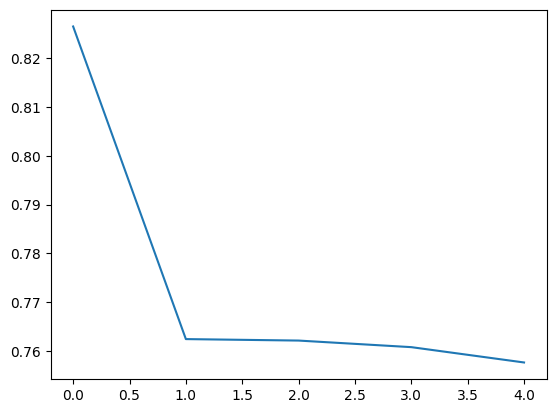

In [13]:
plt.plot([i for i in range(len(loss_list_epoch))], loss_list_epoch)
plt.show()

In [14]:
param_arr = np.array(param_list).transpose()
print(param_arr)

[[4.2929430e+00 4.2907963e+00 4.2886510e+00 ... 5.9268319e-11
  5.9238683e-11 5.9209061e-11]
 [1.9618807e+00 1.9608997e+00 1.9599192e+00 ... 2.7085547e-11
  2.7072004e-11 2.7058468e-11]]


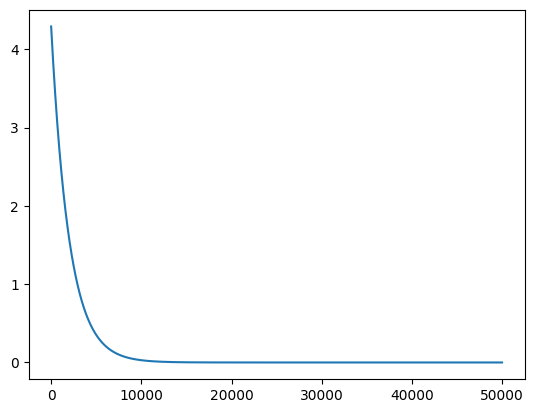

In [15]:
plt.plot([i for i in range(param_arr.shape[1])], param_arr[0])
plt.show()

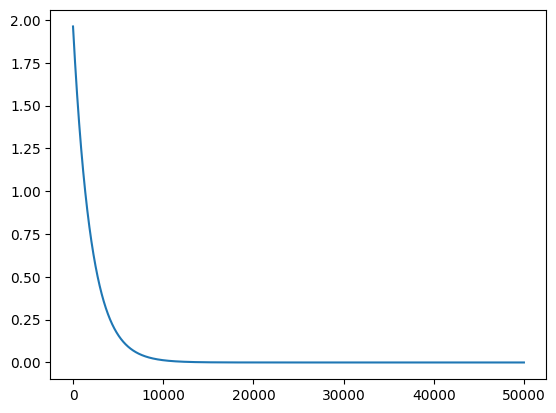

In [16]:
plt.plot([i for i in range(param_arr.shape[1])], param_arr[1])
plt.show()

In [17]:
pqc_model.pqc_params

Parameter containing:
tensor([5.9209e-11, 2.7058e-11], requires_grad=True)

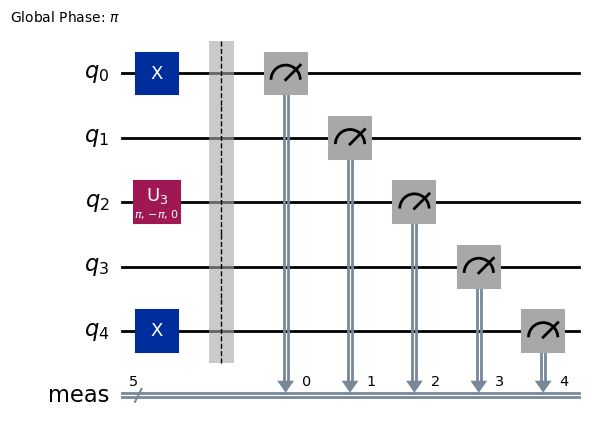

In [18]:
mcirc = get_circuit_for_model(INPUT_BITS, append_inverse(custom_ghz(NUM_QUBITS,2)))
mcirc_measured = mcirc.measure_all(inplace=False)
transpiled_circ = transpile(mcirc_measured, custom_noisy_sim)
transpiled_circ.draw('mpl')

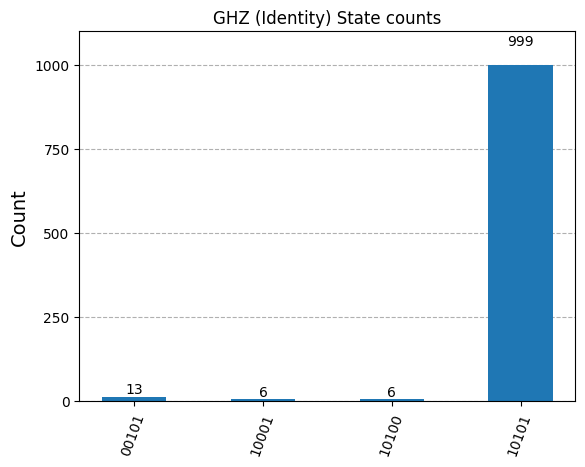

In [19]:
result = custom_noisy_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
counts = result.get_counts(transpiled_circ)

plot_histogram(counts, title='GHZ (Identity) State counts')

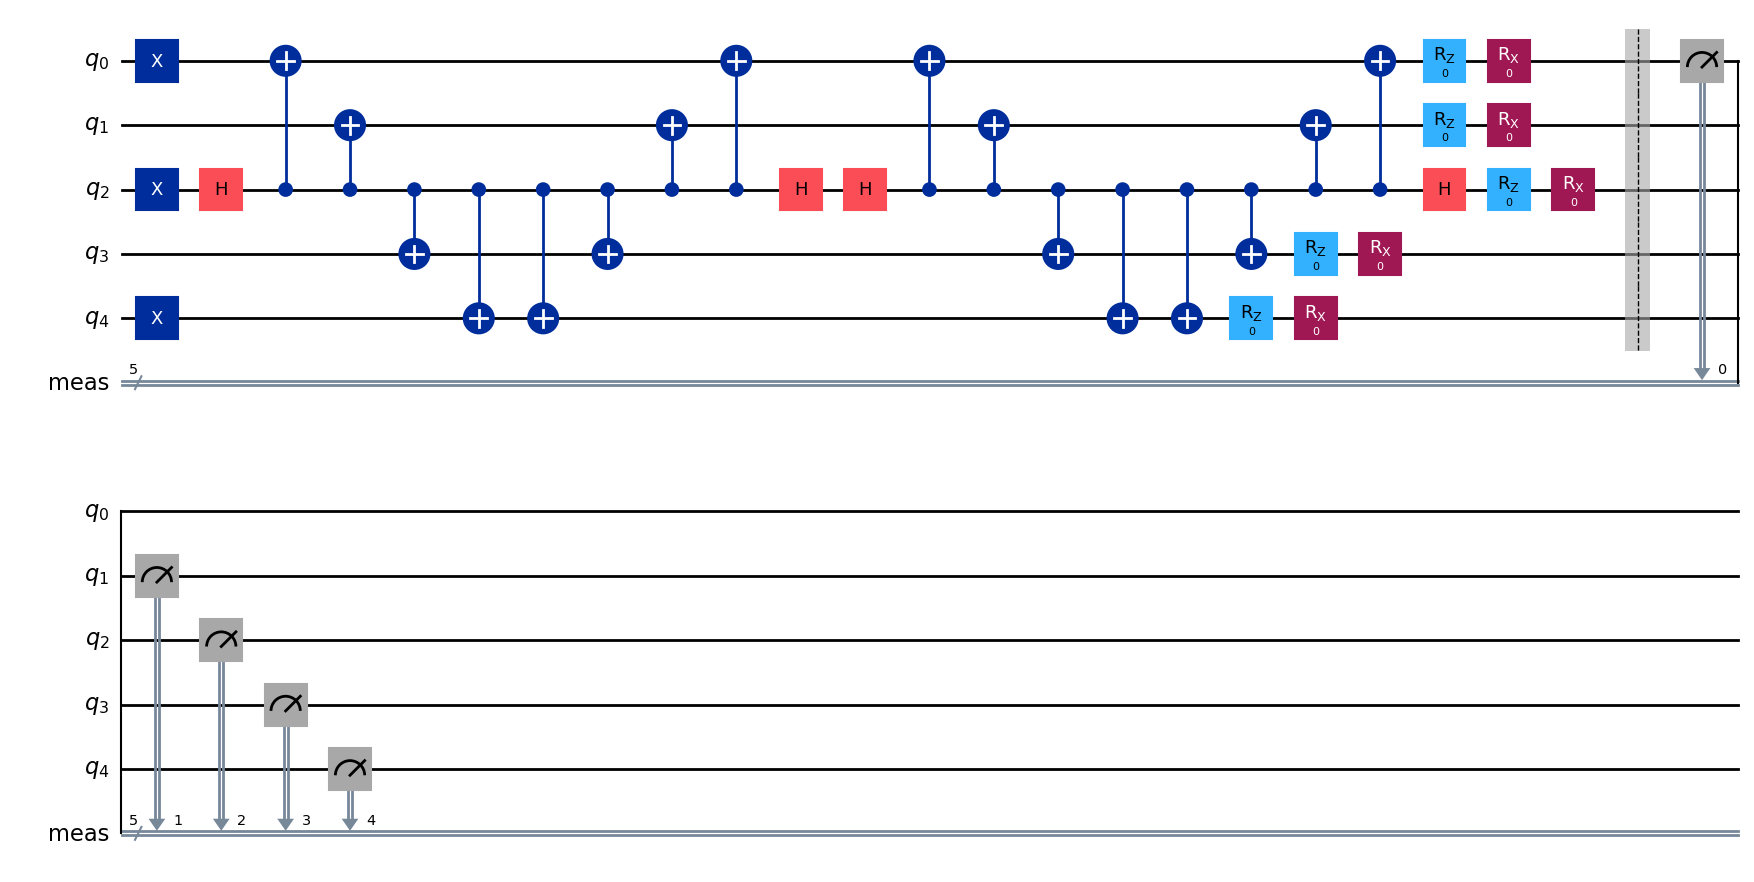

In [20]:
mcirc_post = append_pqc_to_quantum_circuit(mcirc, pqc_model.pqc_params, pqc_arch)
mcirc_post.draw('mpl')

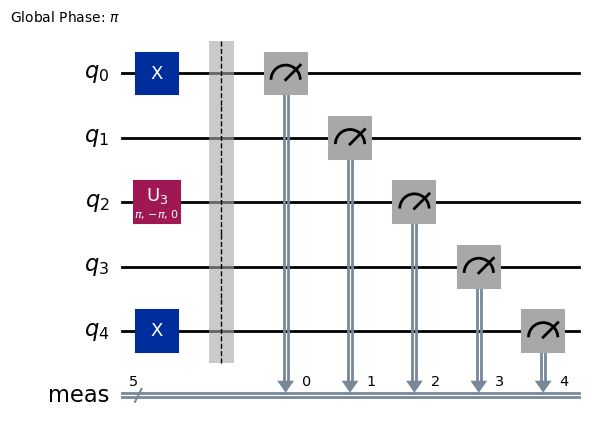

In [21]:

transpiled_circ = transpile(mcirc_post, custom_noisy_sim)
transpiled_circ.draw('mpl')

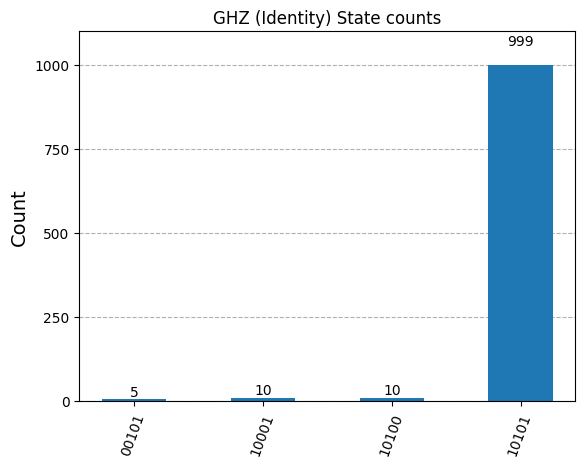

In [22]:
result = custom_noisy_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
counts = result.get_counts(transpiled_circ)

plot_histogram(counts, title='GHZ (Identity) State counts')

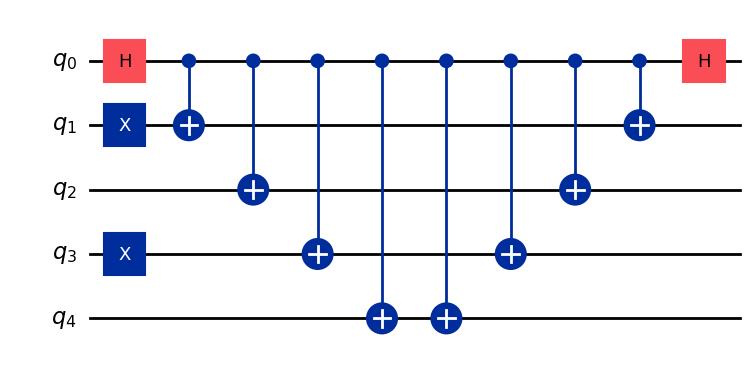

In [23]:
mcirc = get_circuit_for_model('01010', custom_ghz(NUM_QUBITS,0))
mcirc.draw('mpl')

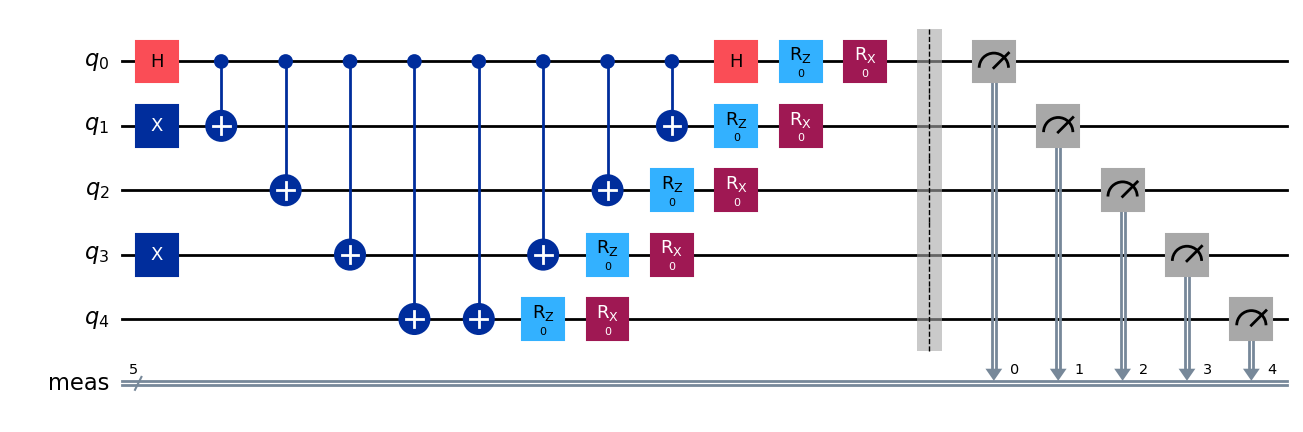

In [24]:
mcirc_post = append_pqc_to_quantum_circuit(mcirc, pqc_model.pqc_params, pqc_arch)
mcirc_post.draw('mpl')

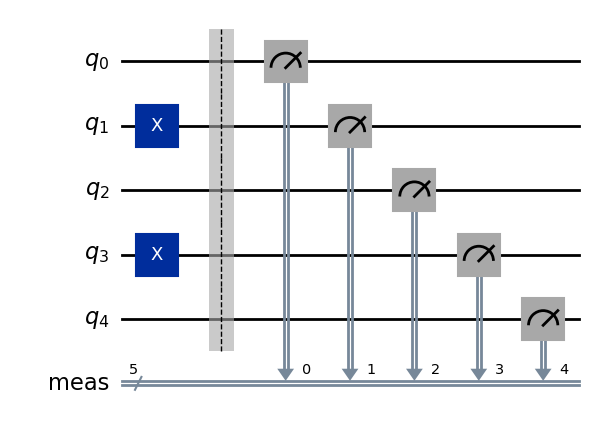

In [25]:
transpiled_circ = transpile(mcirc_post, custom_noisy_sim)
transpiled_circ.draw('mpl')

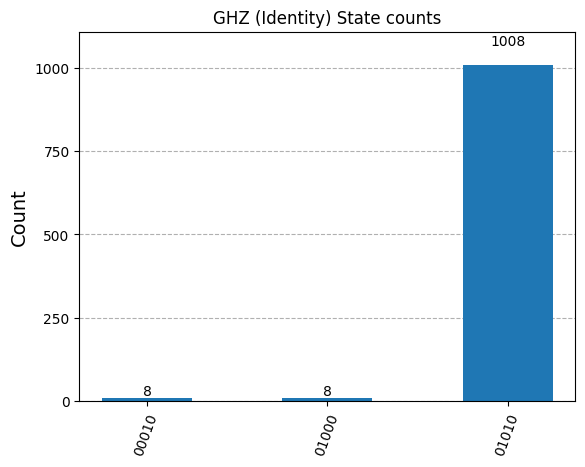

In [26]:
result = custom_noisy_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
counts = result.get_counts(transpiled_circ)

plot_histogram(counts, title='GHZ (Identity) State counts')